<h1 align="center">  DISCLAIMER </h1>
<p>Guys, everything that you see in the kernel you can freely take, copy, modify and create your own amazing solutions!</p>
<p>If you don't want to waste your time - just read 'briefly' section I made for you.</p>
<p>Do not forget upvote if the kernel was useful for you.</p>
<img src="https://i.gifer.com/7lDV.gif">

<h1>TODO-list</h1>
<ul>
    <li>Add more new features  means it's CLUSTERING</li>
    <li>Add extra features indicating the feature value is absent</li>
    <li>Try to stack some models or just investigate how to do it</li>
</ul>

<h1>
    Imports
</h1>

In [1]:
import sys
import warnings

import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.regressor import StackingCVRegressor
from scipy.stats import skew
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor


print("Imports have been set")

# Disabling warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Imports have been set


<h1>
    Input data handling
</h1>
<span> Briefly:
    <ul>
        <li> removing rows with NaN in Sale Price </li>
        <li> logarithm SalePrice (and when model predicts I use np.expm1 function to return value)  </li>
        <li> splitting X to target variable y and train_features </li>
        <li> joining X_test and train_features to process all features together </li>
    </ul>
</span>

In [2]:
# Reading the training/val data and the test data
X = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# Rows before:
rows_before = X.shape[0]
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
rows_after = X.shape[0]
print("\nRows containing NaN in SalePrice were dropped: " + str(rows_before - rows_after))

# Logarithming target variable in order to make distribution better
X['SalePrice'] = np.log1p(X['SalePrice'])

y = X['SalePrice'].reset_index(drop=True)
train_features = X.drop(['SalePrice'], axis=1)

# concatenate the train and the test set as features for tranformation to avoid mismatch
features = pd.concat([train_features, X_test]).reset_index(drop=True)
print('\nFeatures size:', features.shape)


Rows containing NaN in SalePrice were dropped: 0

Features size: (2919, 79)


<h1>
    Checking for NaNs and printing them
</h1>
<span> Briefly:
    <ul>
        <li> printing NaN-containing columns names </li>
        <li> printing NaN-containing columns values for clarity</li>
    </ul>
</span>

In [3]:
nan_count_table = (features.isnull().sum())
nan_count_table = nan_count_table[nan_count_table > 0].sort_values(ascending=False)
print("\nColums containig NaN: ")
print(nan_count_table)

columns_containig_nan = nan_count_table.index.to_list()
print("\nWhat values they contain: ")
print(features[columns_containig_nan])


Colums containig NaN: 
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

What values they contain: 
     PoolQC MiscFeature Alley  Fence FireplaceQu  LotFrontage GarageFinish  \
0       NaN         NaN   NaN    NaN         NaN         65.0          RFn   
1       NaN         NaN   NaN    NaN          TA         80.0    

<h1>
    Feature engineering
</h1>
<span> Briefly:
    <ul>
        <li> Filling with 0 numeric columns </li>
        <li> Filling with 'None' categoric columns where 'NA' meant 'other' value</li>
        <li> Filling with the most frequent values categoric columns where 'NA' meant 'nothing is here'</li>
        <li> Turning to 'str' columns which are actually categoric </li>
        <li> Turning to 'int' columns which are actually numeric </li>
    </ul>
</span>

In [4]:
for column in columns_containig_nan:

    # populating with 0
    if column in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'TotalBsmtSF',
                  'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
                  'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea']:
        features[column] = features[column].fillna(0)

    # populate with 'None'
    if column in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', "PoolQC", 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                  'BsmtFinType2', 'Neighborhood', 'BldgType', 'HouseStyle', 'MasVnrType', 'FireplaceQu', 'Fence', 'MiscFeature']:
        features[column] = features[column].fillna('None')

    # populate with most frequent value for cateforic
    if column in ['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'RoofStyle',
                  'Electrical', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'RoofMatl', 'ExterQual', 'ExterCond',
                  'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']:
        features[column] = features[column].fillna(features[column].mode()[0])

# MSSubClass: Numeric feature. Identifies the type of dwelling involved in the sale.
#     20  1-STORY 1946 & NEWER ALL STYLES
#     30  1-STORY 1945 & OLDER
#     40  1-STORY W/FINISHED ATTIC ALL AGES
#     45  1-1/2 STORY - UNFINISHED ALL AGES
#     50  1-1/2 STORY FINISHED ALL AGES
#     60  2-STORY 1946 & NEWER
#     70  2-STORY 1945 & OLDER
#     75  2-1/2 STORY ALL AGES
#     80  SPLIT OR MULTI-LEVEL
#     85  SPLIT FOYER
#     90  DUPLEX - ALL STYLES AND AGES
#    120  1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#    150  1-1/2 STORY PUD - ALL AGES
#    160  2-STORY PUD - 1946 & NEWER
#    180  PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#    190  2 FAMILY CONVERSION - ALL STYLES AND AGES

# Stored as number so converted to string.
features['MSSubClass'] = features['MSSubClass'].apply(str)
features["MSSubClass"] = features["MSSubClass"].fillna("Unknown")
# MSZoning: Identifies the general zoning classification of the sale.
#    A    Agriculture
#    C    Commercial
#    FV   Floating Village Residential
#    I    Industrial
#    RH   Residential High Density
#    RL   Residential Low Density
#    RP   Residential Low Density Park
#    RM   Residential Medium Density

# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# LotFrontage: Linear feet of street connected to property
# Groupped by neighborhood and filled in missing value by the median LotFrontage of all the neighborhood
# TODO may be 0 would perform better than median?
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# LotArea: Lot size in square feet.
# Stored as string so converted to int.
features['LotArea'] = features['LotArea'].astype(np.int64)
# Alley: Type of alley access to property
#    Grvl Gravel
#    Pave Paved
#    NA   No alley access

# So. If 'Street' made of 'Pave', so it would be reasonable to assume that 'Alley' might be 'Pave' as well.
features['Alley'] = features['Alley'].fillna('Pave')
# MasVnrArea: Masonry veneer area in square feet
# Stored as string so converted to int.
features['MasVnrArea'] = features['MasVnrArea'].astype(np.int64)

<h1>
    Adding new features
</h1>
<span> Briefly:
    <ul>
        <li> YrBltAndRemod means overall sum of years </li>
        <li> Separating to the other features overall squares</li>
        <li> Separating to the other features presence/absence of a garage and so on</li>
    </ul>
</span>

In [5]:
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# If area is not 0 so creating new feature looks reasonable
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print('Features size:', features.shape)

Features size: (2919, 89)


<h1>
    Let's check if we filled all the gaps
</h1>
<span> Briefly:
    <ul>
        <li> Just printing True or False if all the gaps are filled </li>
    </ul>
</span>

In [6]:
nan_count_train_table = (features.isnull().sum())
nan_count_train_table = nan_count_train_table[nan_count_train_table > 0].sort_values(ascending=False)
print("\nAre no NaN here now: " + str(nan_count_train_table.size == 0))


Are no NaN here now: True


<h1>
    Fixing skewed values
</h1>
<span> Briefly:
    <ul>
        <li> Checking skewness of all the numeric features and logarithm it if more than 0.7 </li>
    </ul>
</span>

In [7]:
numeric_columns = [cname for cname in features.columns if features[cname].dtype in ['int64', 'float64']]
print("\nColumns which are numeric: " + str(len(numeric_columns)) + " out of " + str(features.shape[1]))
print(numeric_columns)

categoric_columns = [cname for cname in features.columns if features[cname].dtype == "object"]
print("\nColumns whice are categoric: " + str(len(categoric_columns)) + " out of " + str(features.shape[1]))
print(categoric_columns)

skewness = features[numeric_columns].apply(lambda x: skew(x))
print(skewness.sort_values(ascending=False))


Columns which are numeric: 45 out of 89
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'YrBltAndRemod', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'hasfireplace']

Columns whice are categoric: 44 out of 89
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 


Skewed values: Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'TotalSF', 'Total_sqr_footage', 'Total_porch_sf', 'haspool',
       'hasgarage', 'hasbsmt'],
      dtype='object')

Let's see and compare skewed features


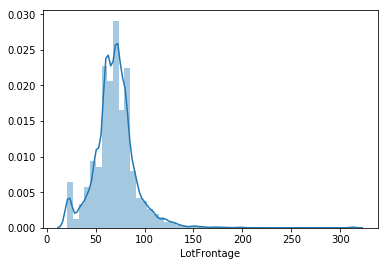

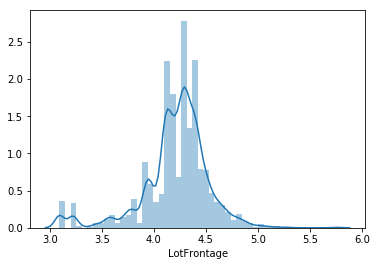

---------------------------------------------------


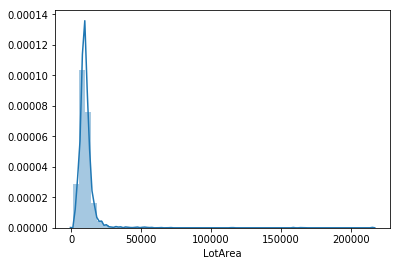

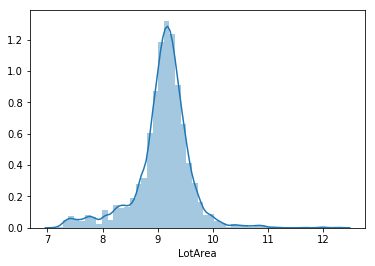

---------------------------------------------------


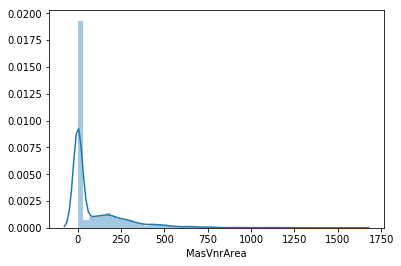

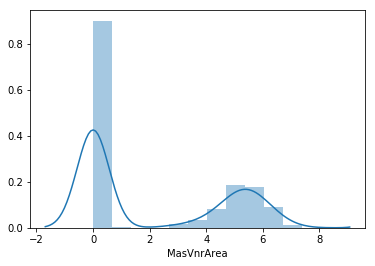

---------------------------------------------------


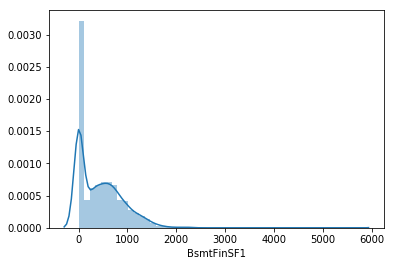

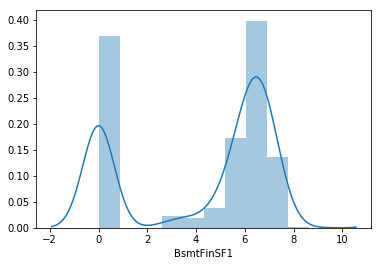

---------------------------------------------------


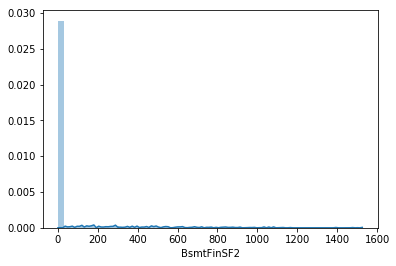

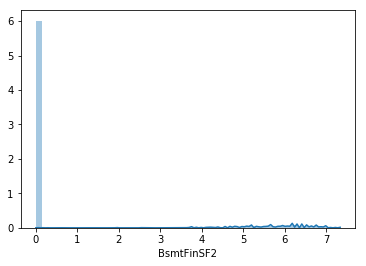

---------------------------------------------------

Skewed values: Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'TotalSF', 'Total_sqr_footage', 'Total_porch_sf', 'haspool',
       'hasgarage', 'hasbsmt'],
      dtype='object')


In [8]:
skewness = skewness[abs(skewness) > 0.7]
print("\nSkewed values: " + str(skewness.index))
fixed_features = np.log1p(features[skewness.index])

print("\nLet's see and compare skewed features")
for column in skewness.index[0:5]:
    sns.distplot(features[column])
    plt.show()
    sns.distplot(fixed_features[column])
    plt.show()
    print("---------------------------------------------------")
    


print("\nSkewed values: " + str(skewness.index))
features[skewness.index] = np.log1p(features[skewness.index])

<h1>
    Categoric features encoding and splitting to train and test data
</h1>
<span> Briefly:
    <ul>
        <li> I used pd.get_dummies(features) which returns kind of One-Hot encoded categoric features</li>
        <li> Splitted to X and X_test by y length</li>
    </ul>
</span>

In [9]:
# Kind of One-Hot encoding
final_features = pd.get_dummies(features).reset_index(drop=True)

# Spliting the data back to train(X,y) and test(X_sub)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]
print('Features size for train(X,y) and test(X_test):')
print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

Features size for train(X,y) and test(X_test):
X (1460, 326) y (1460,) X_test (1459, 326)


<h1>
    ML part (models initialization)
</h1>
<span> Briefly:
    <ul>
        <li> I used pd.get_dummies(features) as encoder which returns kind of One-Hot encoded categoric features</li>
        <li> Splitted to X and X_test by y length</li>
    </ul>
</span>

In [10]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

# check maybe 10 kfolds would be better
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=14, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

# Gradient Boosting for regression
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

# LightGBM regressor.
lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                         learning_rate=0.05, n_estimators=720,
                         max_bin=55, bagging_fraction=0.8,
                         bagging_freq=5, feature_fraction=0.2319,
                         feature_fraction_seed=9, bagging_seed=9,
                         min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

# optimal parameters, received from CV
c_grid = {"n_estimators": [1000],
          "early_stopping_rounds": [1],
          "learning_rate": [0.1]}
xgb_regressor = XGBRegressor(objective='reg:squarederror')
cross_validation = KFold(n_splits=10, shuffle=True, random_state=2)
xgb_r = GridSearchCV(estimator=xgb_regressor,
                     param_grid=c_grid,
                     cv=cross_validation)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lgbm, gboost),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

<h1>
    ML part (models fitting)
</h1>
<span> Briefly:
    <ul>
        <li> One-by-one all models fitting</li>
        <li> Printing models scores (might be commented for quicker work) </li>
    </ul>
</span>

In [11]:
print('\n\nFitting our models ensemble: ')

print('Elasticnet is fitting now...')
elastic_model = elasticnet.fit(X, y)
print('Lasso is fitting now...')
lasso_model = lasso.fit(X, y)
print('Ridge is fitting now...')
ridge_model = ridge.fit(X, y)
print('XGB is fitting now...')
xgb_model = xgb_r.fit(X, y)
print('Gradient Boosting regressor is fitting now...')
gboost_model = gboost.fit(X, y)
print('LGBMRegressor is fitting now...')
lgbm_model = lgbm.fit(X, y)
print('stack_gen is fitting now...')
stack_gen_model = stack_gen.fit(X, y)
print('SVR is fitting now...')
svr_model = svr.fit(X, y)


# model scoring and validation function
# def cv_rmse(the_model, x):
#     return np.sqrt(-cross_val_score(the_model, x, y, scoring="neg_mean_squared_error", cv=kfolds))


# print('\n\nModels evaluating: ')
# score = cv_rmse(ridge_model, X)
# print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(lasso_model, X)
# print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(elastic_model, X)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(xgb_model, X)
# print("xgb_r score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(gboost_model, X)
# print("Gradient boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(lgbm_model, X)
# print("LGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(stack_gen_model, X)
# print("Stack gen score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(svr_model, X)
# print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Fitting our models ensemble: 
Elasticnet is fitting now...
Lasso is fitting now...
Ridge is fitting now...
XGB is fitting now...
Gradient Boosting regressor is fitting now...
LGBMRegressor is fitting now...
stack_gen is fitting now...
SVR is fitting now...


<h1>
    ML part (models ensembling)
</h1>
<span> Briefly:
    <ul>
        <li> The weighted sum of models on the basis of which the solution is assembled</li>
        <li> There is score in comment to each row which explains coefficient to model</li>
    </ul>
</span>

In [12]:
# Last successful: 0.11663
# Try to increase stack_gen and try it manually
# [0.2, 0.1, 0.2, 0.2, 0.0, 0.2, 0.1, 0.0] - 0.11383
def blend_models(x):
    return (0.20 * stack_gen_model.predict(x) +    # 0.1236 (0.0232)
            0.10 * gboost_model.predict(x) +      # 0.1249 (0.0208)
            0.20 * elastic_model.predict(x) +    # 0.1266 (0.0221)
            0.20 * lasso_model.predict(x) +     # 0.1267 (0.0221)
            0.00 * lgbm_model.predict(x) +     # 0.1272 (0.0198)
            0.20 * svr_model.predict(x) +     # 0.1273 (0.0247)
            0.10 * xgb_model.predict(x) +     # 0.1283 (0.0168)
            0.00 * ridge_model.predict(x))  # 0.1301 (0.0216)


def rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_error(y_actual, y_pred))


print('\nRMSLE score on train data:')
print(rmsle(y, blend_models(X)))


RMSLE score on train data:
0.09150895343859103


In [13]:
importance = gboost_model.feature_importances_
importance.sort(axis=0)

plt.figure(figsize=(200,100))
plt.plot(importance)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

<h1>Model improvements history to see how various changes affect the performance of the model</h1>
<span>

            
1. Initial start only with XGBoost:
            - RMSLE: 0.13901
            
2. Added 'SalePrice' logarithming:
             - RMSLE: 0.13984 ↗
             - Review: For now it made performance worse. Reasons are unknown.
            
3. Added huge amount of feature engineering:
             - RMSLE: 0.13490 ↘
             - Review: Obviously this makes sense
            
4. Used Label encoder instead of get_dummies():
             - RMSLE: 0.13630 ↗
             - Review: get_dummies performs better by it's kind of OH-encoding
            
5. Aded skew-features fix:
             - RMSLE: 0.13494 ↗
             - Review: It is just a bit better than 0.13490 (launch after feature engineering)
            
6. Created models ensemble: ridge, lasso, elasticnet, gbr, xgboost:
             - RMSLE: 0.11759 ↘
             - Review: Sure. Models ensemble would make magic.
            
7. Added KernelRidge, Gradient Boosting and LGBMRegressor to ensemble and sum made weighted:
             - RMSLE: 0.11638 ↘
             - Review: Very nice! Keep going!
            
8. Added SVR and Stack Gen:
             - RMSLE: 0.11534 ↘
             - Review: Nice as well, but here comes question with coefficients.
            
9. Made coefficiential bruteforce:
             - RMSLE: 0.11506 ↘
             - Review: Looks promising. It's hard to imagine how lot depends on coefficients regardless of your model.            
</span>


In [14]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:, 1] = np.expm1(blend_models(X_test))
submission.to_csv("submission.csv", index=False)

print("Submission file is formed")

Submission file is formed
